# Unfold

- Closure Tests and Fake Data Tests
- Only need MC stat and GENIE syst

In [953]:
# %load_ext autoreload
# %autoreload 2

# #print all output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [954]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm
import pickle

# local imports
from variable_configs import *

sys.path.append('../../')
from analysis_village.unfolding.wienersvd import *
from analysis_village.unfolding.unfolding_inputs import *
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from makedf.geniesyst import regen_systematics_sbnd_multisigma, regen_systematics_sbnd_morph
from makedf.constants import *

plt.style.use("presentation.mplstyle")

# filter Performance warning
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [955]:
save_fig = True
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/unfolding_tests"

# load dataframes

In [956]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"

## -- MC 
# selected
mc_file = path.join(file_dir, "MC_bnb_cosmics_finalsel.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 5
Keys: ['/evt_0', '/evt_1', '/evt_2', '/evt_3', '/evt_4', '/hdr_0', '/hdr_1', '/hdr_2', '/hdr_3', '/hdr_4', '/mcnu_0', '/mcnu_1', '/mcnu_2', '/mcnu_3', '/mcnu_4', '/split']


In [957]:
# concat dfs 
n_max_concat = 20

mc_keys2load = ['hdr', 'evt', 'mcnu']
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']
mc_nu_df = mc_dfs['mcnu']

In [958]:
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name
P_mu_col = pad_column_name(("totp",), mc_nu_df.mu)
P_p_col = pad_column_name(("totp",), mc_nu_df.p)
ret_tki = get_cc1p0pi_tki(mc_nu_df.mu, mc_nu_df.p, P_mu_col, P_p_col)
mc_nu_df["del_Tp"] = ret_tki["del_Tp"]
mc_nu_df["del_Tp_x"] = ret_tki["del_Tp_x"]
mc_nu_df["del_Tp_y"] = ret_tki["del_Tp_y"]
mc_nu_df["del_p"] = ret_tki["del_p"]
mc_nu_df["del_alpha"] = ret_tki["del_alpha"]
mc_nu_df["del_phi"] = ret_tki["del_phi"]

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [959]:
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.10e" %(mc_tot_pot))

# mc_pot_scale = data_tot_pot / mc_tot_pot
mc_pot_scale = 1.0
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_tot_pot: 5.8562716084e+20
mc_pot_scale: 1.000e+00


In [960]:
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_evt_df.loc[:,'genie_categ'] = get_genie_category(mc_evt_df)
print(mc_evt_df.nuint_categ.value_counts())
print(mc_evt_df.genie_categ.value_counts())

mc_nu_df.loc[:,'nuint_categ'] = get_int_category(mc_nu_df)
mc_nu_df.loc[:,'genie_categ'] = get_genie_category(mc_nu_df)
print(mc_nu_df.nuint_categ.value_counts())
print(mc_nu_df.genie_categ.value_counts())

nuint_categ
 1    73575
 2     2279
 3     2238
 4     1176
-1      393
 5       98
 0       82
Name: count, dtype: int64
genie_categ
 1    65266
 2     9586
 3     3130
 6     1176
-1      393
 4      101
 7       98
 0       82
 5        9
Name: count, dtype: int64
nuint_categ
0    8678581
3    1296685
4     941525
1     744745
2     328118
5      55677
Name: count, dtype: int64
genie_categ
0    8678581
1    1253365
6     941525
3     668227
2     317791
4     125984
7      55677
5       4181
Name: count, dtype: int64


# load covariance matrices

In [961]:
with open("/exp/sbnd/data/users/munjung/xsec/2025B/frac_cov_matrices_uboone.pkl", "rb") as f:
    frac_cov_matrices = pickle.load(f)

frac_cov_matrices.keys()

dict_keys(['mu_dir_z', 'mu_totp', 'p_totp', 'p_dir_z', 'del_Tp', 'del_alpha', 'del_phi'])

# Constants

['flux_sbnd_numu;1', 'flux_sbnd_nue;1', 'flux_sbnd_anumu;1', 'flux_sbnd_anue;1']


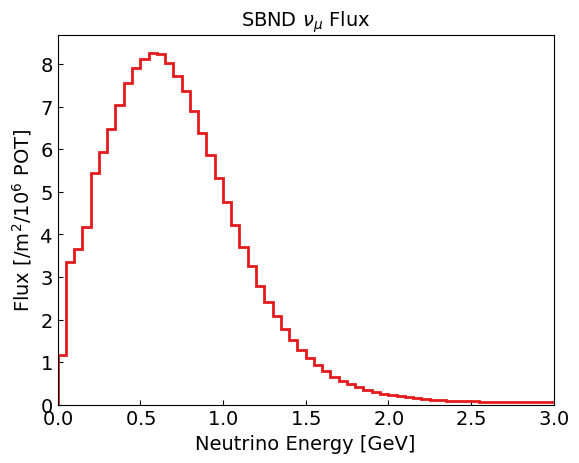

Integrated flux: 9.457e+12


In [962]:
# TODO: z-dependence?
# flux file, units: /m^2/10^6 POT 
# 50 MeV bins
fluxfile = "/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root"
flux = uproot.open(fluxfile)
print(flux.keys())

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

plt.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step", linewidth=2, color="C0")

plt.xlim(0, 3)

plt.xlabel("Neutrino Energy [GeV]")
plt.ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
plt.title("SBND $\\nu_\\mu$ Flux")

# if save_fig:
#     plt.savefig("{}/sbnd-flux.pdf".format(save_fig_dir))
plt.savefig("sbnd-flux.pdf", bbox_inches='tight')
plt.show()

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = integrated_flux * mc_tot_pot / 1e6 # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

In [963]:
V_SBND = 380 * 380 * 440 # cm3, the active volume of the detector 
NTARGETS = RHO * V_SBND * N_A / M_AR
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


In [964]:
# set to 1 for event rates
XSEC_UNIT = 1 / (INTEGRATED_FLUX * NTARGETS)
print("xsec unit: ", XSEC_UNIT)

xsec unit:  7.979527479860288e-44


# Unfold

## Choose variable to unfold

In [1458]:
# choose a variable to unfold, defined in variable_configs.py
# var_config = VariableConfig.muon_momentum()
# var_config = VariableConfig.muon_direction()
# var_config = VariableConfig.proton_momentum()
# var_config = VariableConfig.proton_direction()
# var_config = VariableConfig.tki_del_Tp()
# var_config = VariableConfig.tki_del_alpha()
var_config = VariableConfig.tki_del_phi()

In [1459]:
# Total MC reco muon momentum: for fake data
eps = 1e-8
var_total_mc = mc_evt_df[var_config.var_evt_reco_col]
var_total_mc = np.clip(var_total_mc, var_config.bins[0], var_config.bins[-1] - eps)
weights_total_mc = mc_evt_df.loc[:, 'pot_weight']

# --- all events, selected ---
# mc_evt_df divided into topology modes for subtraction from data in future
# first item in list is the signal topology
mc_evt_df_divided = [mc_evt_df[mc_evt_df.nuint_categ == mode]for mode in topology_list]

# Reco variable distribution for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.nuint_categ == mode][var_config.var_evt_reco_col]for mode in topology_list]
var_per_nuint_categ_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.nuint_categ == mode, 'pot_weight'] for mode in topology_list]

# Reco variable distribution for each genie mode
var_per_genie_mode_mc = [mc_evt_df[mc_evt_df.genie_categ == mode][var_config.var_evt_reco_col]for mode in genie_mode_list]
var_per_genie_mode_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_genie_mode_mc]
weights_per_genie_mode = [mc_evt_df.loc[mc_evt_df.genie_categ == mode, 'pot_weight'] for mode in genie_mode_list]


# --- signal events ---
# selected, for response matrix
# Signal event's reco muon momentum after the event selection
var_signal_sel_reco = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_reco_col]
var_signal_sel_reco = np.clip(var_signal_sel_reco, var_config.bins[0], var_config.bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection
var_signal_sel_truth = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_truth_col]
var_signal_sel_truth = np.clip(var_signal_sel_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# total generated, for efficiency vector
# Signal event's true muon momentum without event selection
var_truth_signal = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_truth_signal = np.clip(var_truth_signal, var_config.bins[0], var_config.bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

# Response Matrix

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[284596. 173011.  87369.  48777.  27601.  30290.  22706.  18003.  17749.
  13311.  10563.  10686.]
[25254. 17881. 10289.  5991.  3088.  3165.  2306.  1764.  1545.  1002.
   688.   597.]
[27922. 17703.  9581.  5304.  2747.  2903.  2171.  1582.  1500.   941.
   654.   559.]


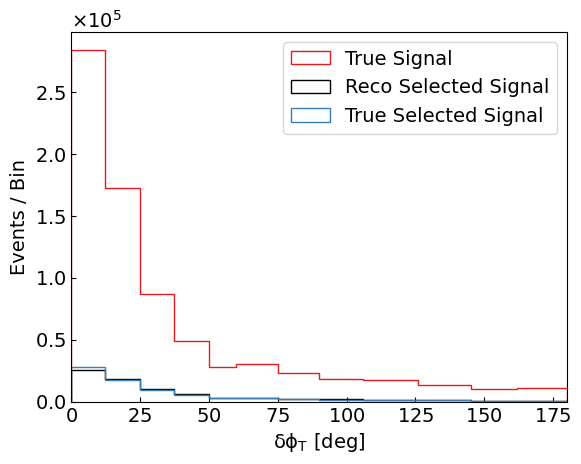

In [1460]:
nevts_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_truth_signal, histtype="step", label="True Signal")
nevts_signal_sel_reco, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=weight_signal, histtype="step", label="Reco Selected Signal", color="k")
nevts_signal_sel_truth, _, _ = plt.hist(var_signal_sel_truth, bins=var_config.bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(nevts_signal_truth)
print(nevts_signal_sel_reco)
print(nevts_signal_sel_truth)
plt.legend()
plt.ylabel("Events / Bin")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
if save_fig:
    plt.savefig("{}/{}-sel_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show();

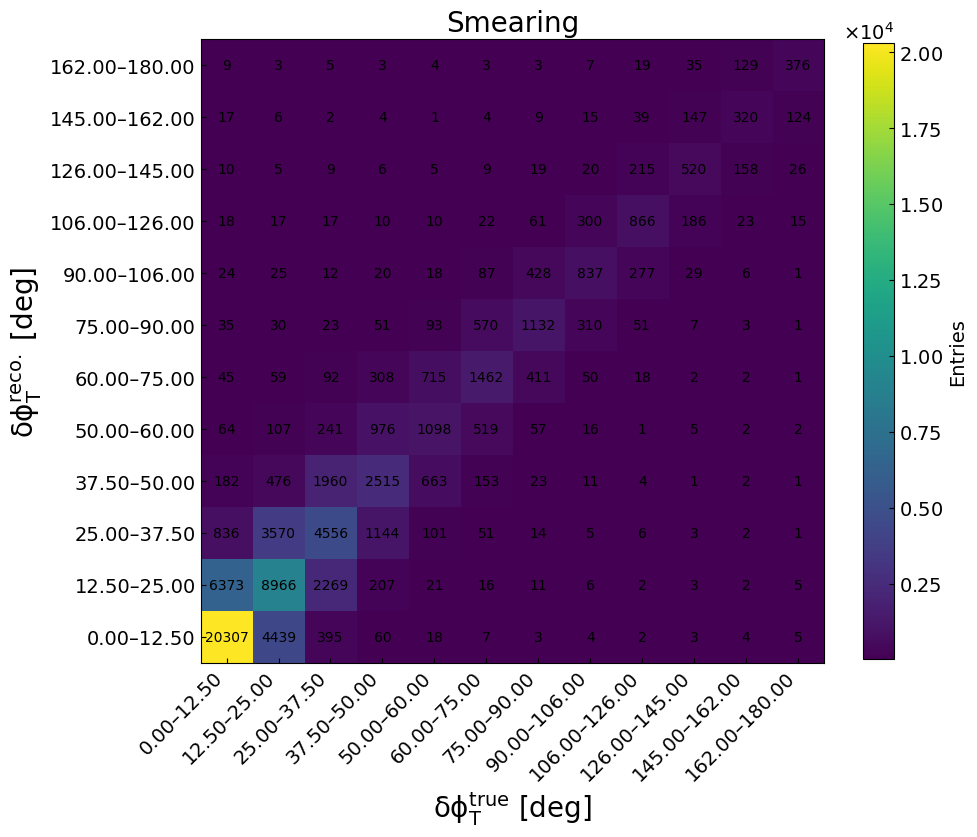

eff
[0.09810398 0.10232297 0.10966132 0.10873977 0.09952538 0.09584021
 0.09561349 0.0878187  0.0845118  0.07069341 0.06181956 0.05221786]


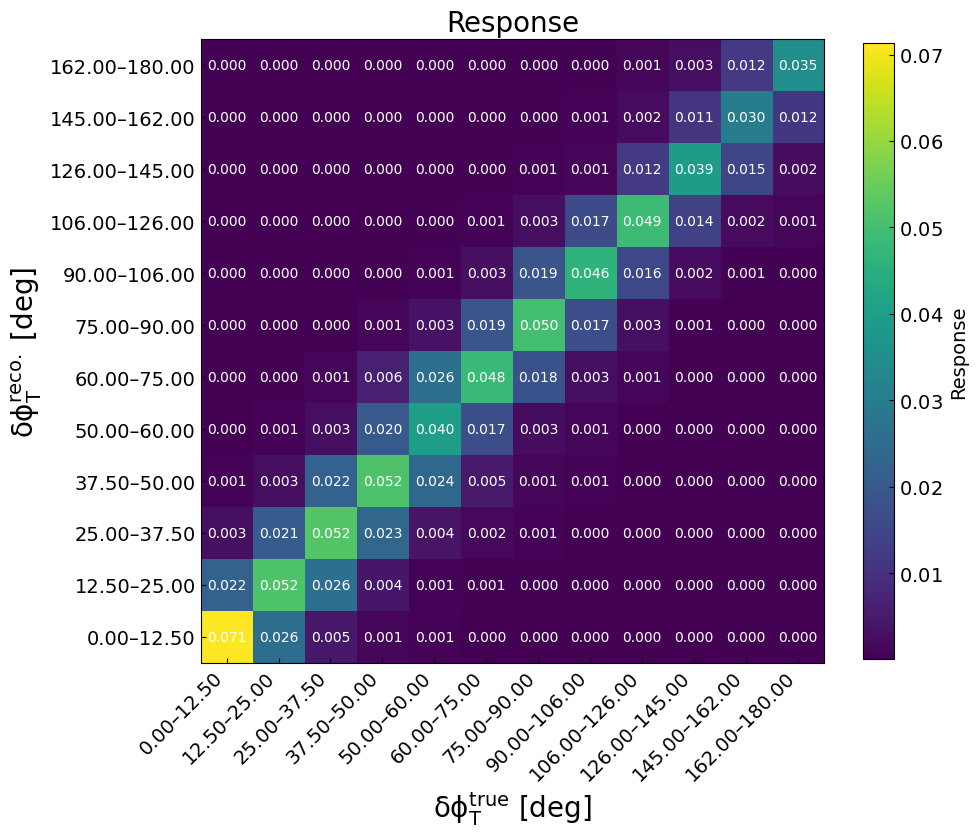

In [1461]:
bins_2d = var_config.bins# = [np.array([0.2, 2]), np.array([0.2, 2])] # commented out lines for 1 bin MC closure test

save_fig_name = "{}/{}-reco_vs_true".format(save_fig_dir, var_config.var_save_name)
reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, bins_2d, var_labels=var_config.var_labels,
                                weights=mc_evt_df[mc_evt_df.nuint_categ == 1]["pot_weight"],
                                save_fig=save_fig, save_fig_name=save_fig_name)
eff = get_eff(reco_vs_true, nevts_signal_truth)
print("eff")
print(eff)

save_fig_name = "{}/{}-response_matrix".format(save_fig_dir, var_config.var_save_name)
Response = get_response_matrix(reco_vs_true, eff, var_config.bins, var_labels=var_config.var_labels,
                               save_fig=save_fig, save_fig_name=save_fig_name)

# Covariance Matrix

In [1462]:
def cov_from_fraccov(cov_frac, cv_vals):
    cov = np.zeros_like(cov_frac)
    for i in range(len(var_config.bins)-1):
        for j in range(len(var_config.bins)-1):
            cov[i, j] = cov_frac[i, j] * (cv_vals[i] * cv_vals[j])
    return cov

def corr_from_fraccov(cov_frac):
    corr = np.zeros_like(cov_frac)
    for i in range(cov_frac.shape[0]):
        for j in range(cov_frac.shape[1]):
            corr[i, j] = cov_frac[i, j] / np.sqrt(cov_frac[i, i] * cov_frac[j, j])
    return corr


In [1463]:
var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])
print(frac_cov_matrices[var_name].keys())
print(frac_cov_matrices[var_name]['flux'].shape)

Total_Covariance_Frac = frac_cov_matrices[var_name]['flux'] + frac_cov_matrices[var_name]['genie'] + frac_cov_matrices[var_name]['cosmics'] + frac_cov_matrices[var_name]['mcstat']

dict_keys(['flux', 'genie', 'cosmics', 'mcstat'])
(12, 12)


In [1464]:
# pretty heatmap plotter

unif_bin = np.linspace(0., float(len(var_config.bins) - 1), len(var_config.bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]

x_edges = np.array(var_config.bins)
y_edges = np.array(var_config.bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

def plot_heatmap(matrix, title, plot_labels=var_config.var_labels, save_fig=False, save_fig_name=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(matrix, extent=extent, origin="lower")
    plt.colorbar(shrink=0.7)
    plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
    plt.yticks(y_tick_positions, y_labels)
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    for i in range(matrix.shape[0]):      # rows (y)
        for j in range(matrix.shape[1]):  # columns (x)
            value = matrix[i, j]
            if not np.isnan(value):  # skip NaNs
                plt.text(
                    j + 0.5, i + 0.5,
                    f"{value:.2f}",
                    ha="center", va="center",   
                    color=get_text_color(value),
                    fontsize=10
                )
    plt.title(title)
    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)
    plt.show();

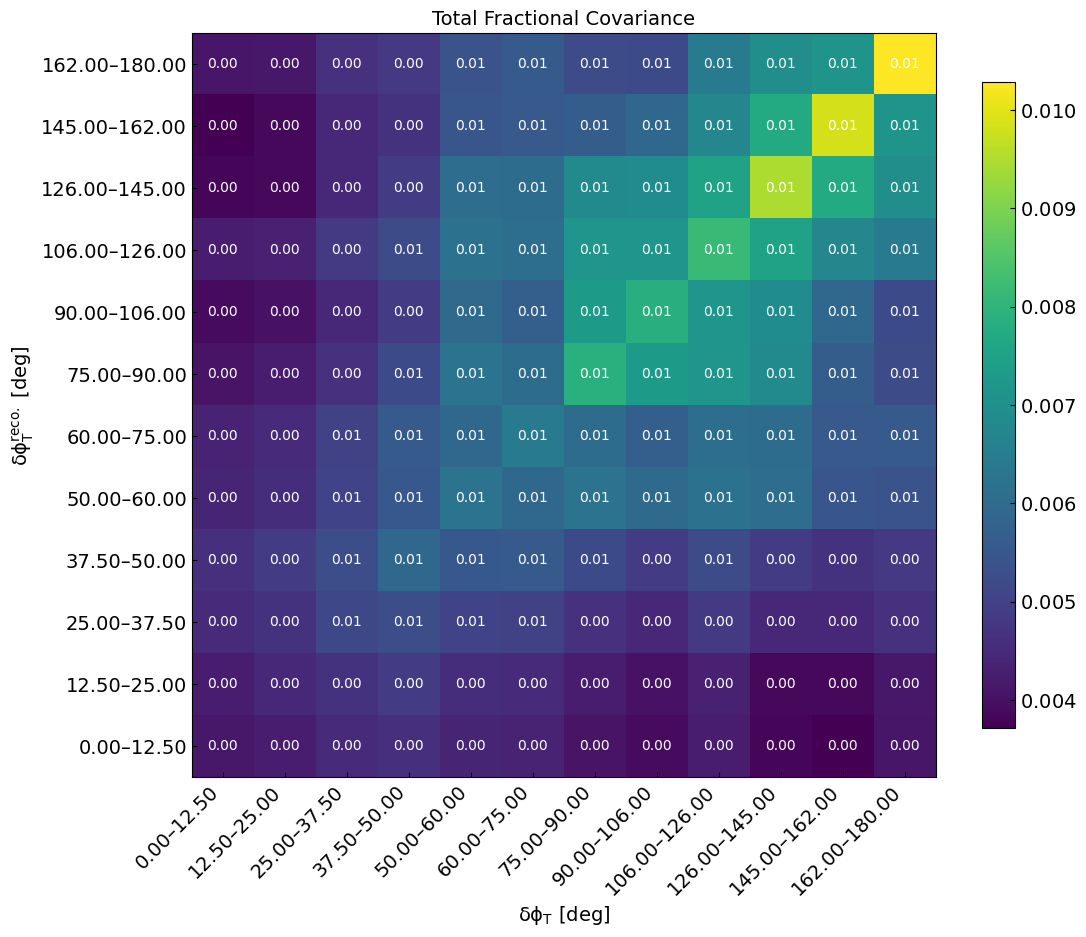

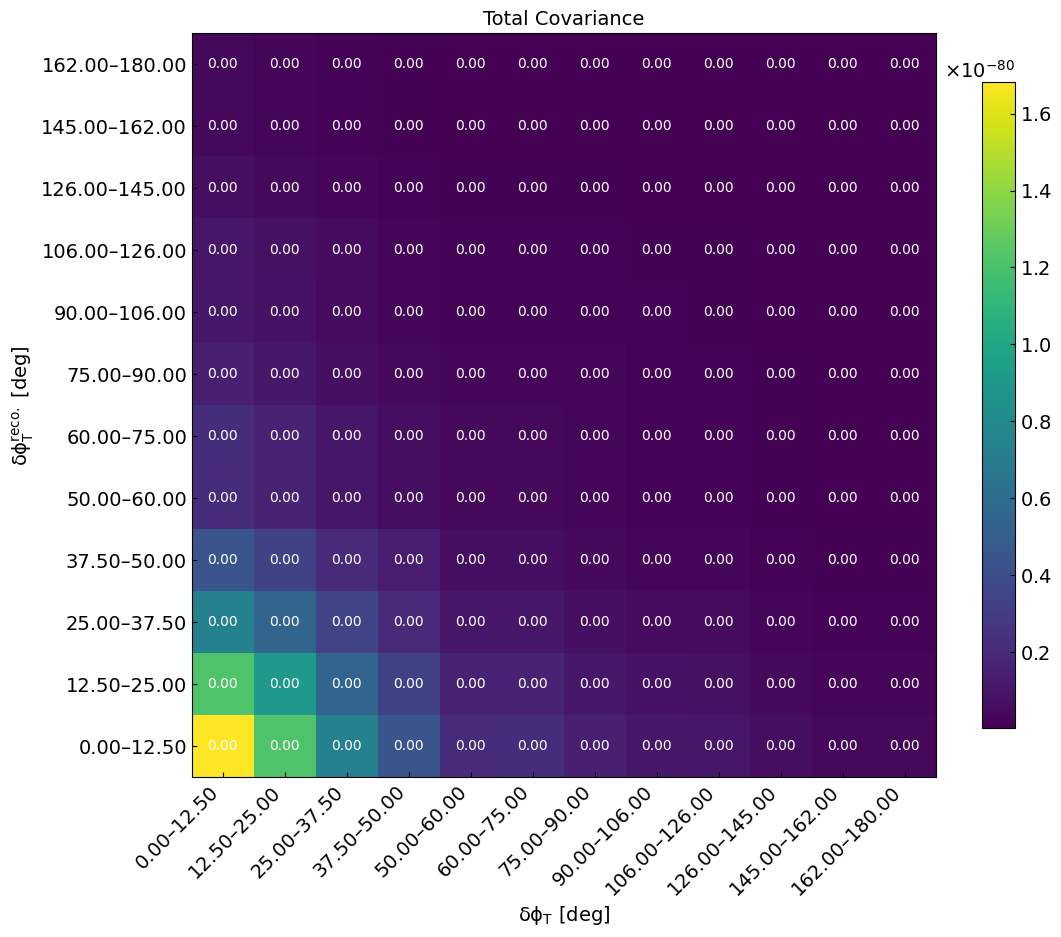

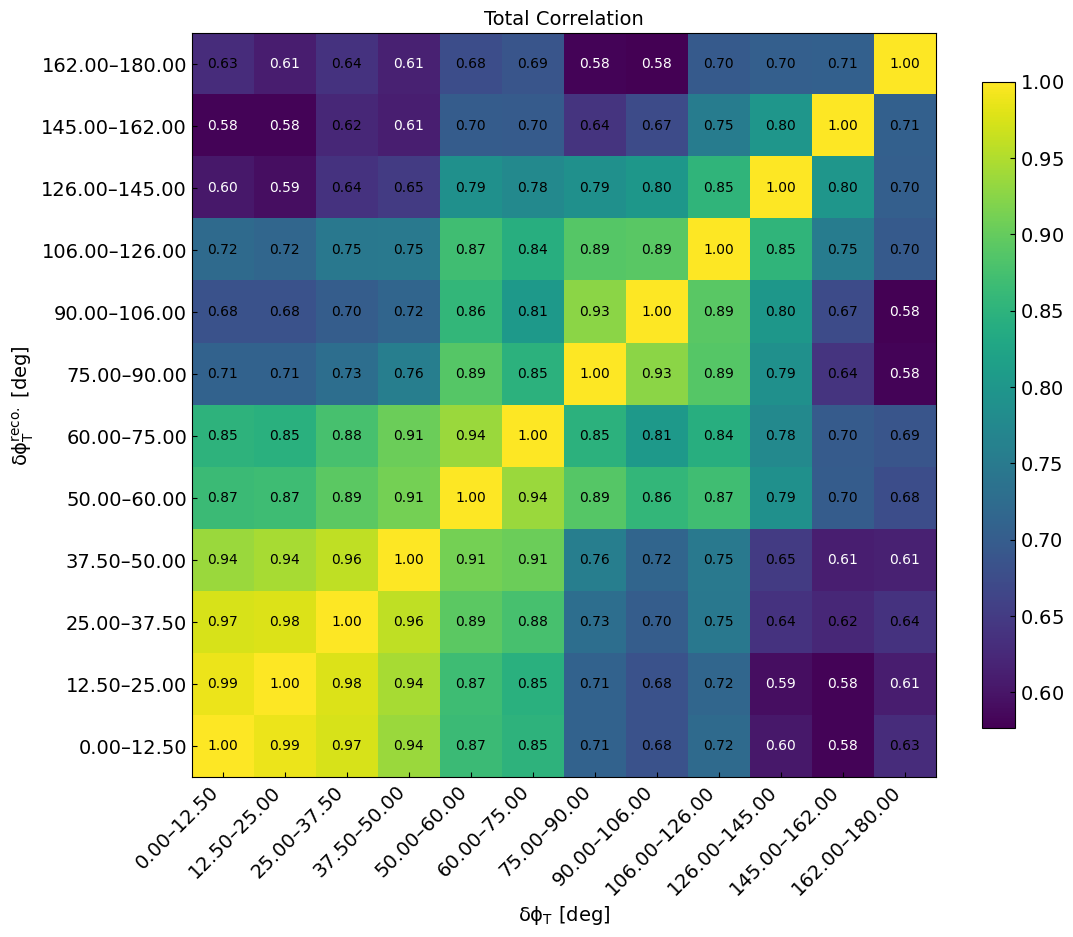

In [1465]:
save_fig_name = "{}/{}-total_covariance_frac".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(Total_Covariance_Frac, "Total Fractional Covariance",
             save_fig=False, save_fig_name=save_fig_name)

# covariance in xsec scale
Total_Covariance = cov_from_fraccov(Total_Covariance_Frac, nevts_signal_sel_reco) * XSEC_UNIT**2
save_fig_name = "{}/{}-total_covariance".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(Total_Covariance, "Total Covariance",
             save_fig=False, save_fig_name=save_fig_name)

# correlation
Total_correlation = corr_from_fraccov(Total_Covariance_Frac)
save_fig_name = "{}/{}-total_correlation".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(Total_correlation, "Total Correlation",
             save_fig=False, save_fig_name=save_fig_name)

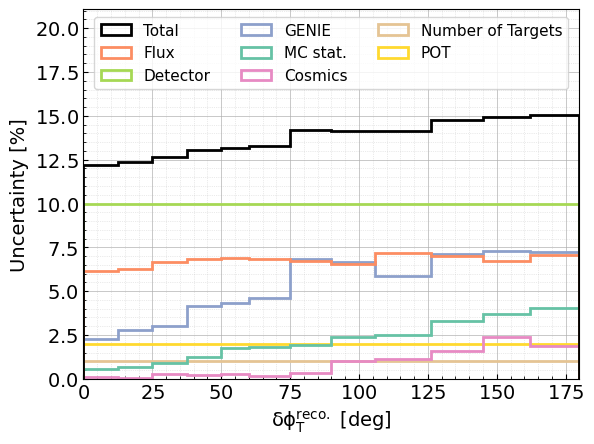

In [1466]:
import matplotlib
import seaborn as sns
# plt.style.use('seaborn-v0_8-colorblind')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=plt.get_cmap('Set2').colors)
# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=sns.color_palette("hls", 8))

frac_uncert_flux     = np.sqrt(np.diag(frac_cov_matrices[var_name]['flux']))
frac_uncert_genie    = np.sqrt(np.diag(frac_cov_matrices[var_name]['genie'])) * 1.25
frac_uncert_cosmics  = np.sqrt(np.diag(frac_cov_matrices[var_name]['cosmics']))
frac_uncert_mcstat   = np.sqrt(np.diag(frac_cov_matrices[var_name]['mcstat']))
# frac_uncert_total    = np.sqrt(np.diag(Total_Covariance_Frac))
frac_uncert_total    = np.sqrt(frac_uncert_flux**2 + frac_uncert_genie**2 + frac_uncert_cosmics**2 + frac_uncert_mcstat**2)

# 10% flat uncertainty for POT
frac_uncert_detector = np.zeros_like(frac_uncert_flux)
frac_uncert_detector[:] = 0.1

# 2% flat uncertainty for POT
frac_uncert_pot = np.zeros_like(frac_uncert_flux)
frac_uncert_pot[:] = 0.02

# 1% for ntargets
frac_uncert_ntargets = np.zeros_like(frac_uncert_flux)
frac_uncert_ntargets[:] = 0.01

# add to total
frac_uncert_total = np.sqrt(frac_uncert_total**2 + frac_uncert_pot**2 + frac_uncert_ntargets**2 + frac_uncert_detector**2)

fig, ax = plt.subplots()
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_pot * 1e2,      histtype="step", linewidth=2, color="C5", label="POT")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_ntargets * 1e2, histtype="step", linewidth=2, color="C6", label="Number of Targets")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_cosmics * 1e2,  histtype="step", linewidth=2, color="C3", label="Cosmics")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_mcstat * 1e2,   histtype="step", linewidth=2, color="C0", label="MC stat.")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie * 1e2,    histtype="step", linewidth=2, color="C2", label="GENIE")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_detector * 1e2, histtype="step", linewidth=2, color="C4", label="Detector")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_flux * 1e2,     histtype="step", linewidth=2, color="C1", label="Flux")

plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_total * 1e2,    histtype="step", linewidth=2, color="k",  label="Total")

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=3, loc="upper center", reverse=True)
plt.ylim(0, max(frac_uncert_total*1e2) * 1.4)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig("{}/uncertainty_breakdown-{}.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show();

# Unfolding

In [1467]:
def plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors, labels, 
                            save_fig=False, save_name=None):

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    plt.figure(figsize=(8.5, 6))

    # TODO: make this more general?
    # our categroy breakdown list have signal at the front
    # stack in reverse order so that signal is on top
    var_categ = var_categ[::-1]
    weights_categ = weights_categ[::-1]
    colors = colors[::-1]
    labels = labels[::-1]
    mc_stack, _, _ = plt.hist(var_categ,
                              bins=bins,
                              weights=weights_categ,
                              stacked=True,
                              color=colors,
                              edgecolor='none',
                              linewidth=0,
                              density=False,
                              histtype='stepfilled')

    # background_cv = mc_stack[-1] - mc_stack[0]
    background_cv = mc_stack[-2]

    # use MC as fake data for closure test
    totmc, _ = np.histogram(var_total, bins=bins, weights=weights_total)
    fake_data     = totmc
    fake_data_err = np.sqrt(totmc)
    plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, 
                 fmt='o', color='black')

    # note the % breakdown in the legend
    accum_sum = [0.] + [np.sum(data) for data in mc_stack]
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels.append("Fake Data")
    plt.legend(legend_labels, 
                loc='upper left', 
                fontsize=10, 
                frameon=False, 
                ncol=3, 
                bbox_to_anchor=(0.02, 0.98))

    n_firsthalf = np.sum(totmc[:len(bins)//2])
    n_secondhalf = np.sum(totmc[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        ha = 'right'
    else:
        textloc_x = 0.05
        ha = 'left'

    plt.text(textloc_x, 0.5, "SBND Simulation\nSBND Preliminary", 
            transform=plt.gca().transAxes, 
            fontsize=12, 
            color='gray',
            ha=ha, 
            va='top')

    # leave whitespace at the top for the legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., 1.45 * fake_data.max())

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()
    
    return fake_data, background_cv

In [1468]:
def plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                         plot_labels, 
                         colors, labels, 
                         save_fig=False, save_name=None):

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    plt.figure(figsize=(8.5, 6))

    # stack in reverse order so that signal is on top 
    var_categ = var_categ[::-1]
    weights_categ = weights_categ[::-1]
    colors = colors[::-1]
    labels = labels[::-1]

    mc_stack, _, _ = plt.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')

    # use MC as fake data for closure test
    totmc, bins = np.histogram(var_total, bins=bins, weights=weights_total)
    fake_data     = totmc
    fake_data_err = np.sqrt(totmc)
    plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, 
                 fmt='o', color='black')

    # note the % breakdown in the legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels.append("Fake Data")
    plt.legend(legend_labels, 
                loc='upper left', 
                fontsize=10, 
                frameon=False, 
                ncol=3, 
                bbox_to_anchor=(0.02, 0.98))

    n_firsthalf = np.sum(totmc[:len(bins)//2])
    n_secondhalf = np.sum(totmc[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        ha = 'right'
    else:
        textloc_x = 0.05
        ha = 'left'

    plt.text(textloc_x, 0.5, "SBND Simulation\nSBND Preliminary", 
            transform=plt.gca().transAxes, 
            fontsize=12, 
            color='gray',
            ha=ha, 
            va='top')

    # leave whitespace at the top for the legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., 1.45 * fake_data.max())

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

In [1469]:
# --- config for Wiener-SVD unfolding ---
C_type = 2
Norm_type = 0.5

## Closure test 
- use MC signal as fake data

In [1470]:
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=plt.get_cmap('Set1').colors)

In [1471]:
def chi2(data, model, cov):
    return (data - model) @ np.linalg.inv(cov) @ (data - model)

In [1472]:
def plot_unfolded_result(unfold, bins, measured, models,
                         plot_labels, model_names, 
                         save_fig=False, save_name=None,
                         closure_test=False):

    # need to divide by bin width for differential xsec
    bin_widths = np.diff(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    fig, ax = plt.subplots(figsize=(8.5, 6))

    # --- stat uncertainties
    UnfoldCov_stat = unfold['StatUnfoldCov']
    Unfold_uncert_stat = np.diag(UnfoldCov_stat)

    # --- syst uncertainties
    UnfoldCov_syst = unfold['SystUnfoldCov']
    Unfold_uncert_syst = np.diag(UnfoldCov_syst)

    # decomose into norm and shape components
    # TODO: the first item in models is the true model
    SystUnfoldCov_norm, SystUnfoldCov_shape = Matrix_Decomp(models[0], UnfoldCov_syst)
    Unfold_uncert_norm = np.sqrt(np.diag(SystUnfoldCov_norm))
    Unfold_uncert_shape = np.sqrt(np.diag(SystUnfoldCov_shape))

    # --- plot
    # unfolded result
    Unfolded = unfold['unfold']
    UnfoldedCov = unfold["UnfoldCov"]
    Unfolded_perwidth = Unfolded / bin_widths

    # set err to 0 for closure test
    if closure_test:
        dummy_err = np.zeros_like(Unfolded_perwidth)
        bar_handle = plt.errorbar(bin_centers, Unfolded_perwidth, yerr=dummy_err, fmt='o', color='black')

    else:
        # plot shape syst and stat as error bars
        Unfold_uncert_stat_perwidth = Unfold_uncert_stat / bin_widths
        Unfold_uncert_shape_perwidth = Unfold_uncert_shape / bin_widths
        # Unfold_uncert_stat_shape_perwidth = Unfold_uncert_stat_perwidth + Unfold_uncert_shape_perwidth
        Unfold_uncert_stat_shape_perwidth = Unfold_uncert_shape_perwidth
        bar_handle = plt.errorbar(bin_centers, Unfolded_perwidth, yerr=Unfold_uncert_stat_shape_perwidth, fmt='o', color='black')

        # plot syst norm component as histogram at the bottom
        Unfold_uncert_norm_perwidth = Unfold_uncert_norm / bin_widths
        norm_handle = plt.bar(bin_centers, Unfold_uncert_norm_perwidth, width=bin_widths, label='Syst. error (norm)', alpha=0.5, color='gray')

    # Also divide measured & model by bin width
    measured_perwidth = measured / bin_widths
    reco_handle, = plt.step(bins, np.append(measured_perwidth, measured_perwidth[-1]), where='post', label='Meausred Signal (Input)')

    # --- get chi2 values for each model to compare
    chi2_vals = []
    model_handles = []
    model_labels = []
    for midx, model in enumerate(models):

        model_smeared = unfold['AddSmear'] @ model
        chi2_val = chi2(Unfolded, model_smeared, UnfoldCov_syst)
        chi2_vals.append(chi2_val)

        model_smeared_perwidth = model_smeared / bin_widths
        model_handle, = plt.step(bins, np.append(model_smeared_perwidth, model_smeared_perwidth[-1]), where='post')
        model_handles.append(model_handle)
        model_labels.append(f'$A_c \\otimes$ {model_names[midx]} ($\chi^2$ = {chi2_vals[midx]:.2f}/{len(bins)-1})')

    # legend
    if closure_test:
        handles = [bar_handle, reco_handle] + model_handles
        labels = ['Unfolded', 'Measured Signal (Input)'] + model_labels
    else:
        handles = [bar_handle, norm_handle, reco_handle] + model_handles
        labels = ['Unfolded', 'Norm. Syst. Unc.', 'Measured Signal (Input)'] + model_labels
    plt.legend(handles, labels, 
               loc='upper left', fontsize=10, frameon=False, ncol=2, bbox_to_anchor=(0.02, 0.98))

    n_firsthalf = np.sum(Unfolded_perwidth[:len(bins)//2])
    n_secondhalf = np.sum(Unfolded_perwidth[len(bins)//2:])
    if n_firsthalf > n_secondhalf:
        textloc_x = 0.95
        ha = 'right'
    else:
        textloc_x = 0.05
        ha = 'left'

    ax.text(textloc_x, 0.5, "SBND Simulation\nSBND Preliminary", 
            transform=ax.transAxes, 
            fontsize=12, 
            color='gray',
            ha=ha, 
            va='top')

    # leave space for legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., np.max(Unfolded_perwidth)*1.4)

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [1473]:
def plot_unfolded_data(unfold, bins, measured, models,
                         plot_labels, model_names,
                         save_fig=False, save_name=None):

    # need to divide by bin width for differential xsec
    bin_widths = np.diff(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    fig, ax = plt.subplots(figsize=(8.5, 6))

    Unfolded = unfold['unfold']

    # --- stat uncertainties
    UnfoldCov_stat = unfold['StatUnfoldCov'] 
    # print(UnfoldCov_stat)
    UnfoldCov_stat = np.diag(measured/XSEC_UNIT)
    # print(UnfoldCov_stat)
    Unfold_uncert_stat = np.diag(UnfoldCov_stat)  * XSEC_UNIT
    # print(Unfold_uncert_stat)
    # print(UnfoldCov_stat)

    # mask = Unfolded != 0
    UnfoldCov_stat_frac = np.zeros_like(UnfoldCov_stat)
    for i in range(len(Unfolded)):
        for j in range(len(Unfolded)):
            if Unfolded[i] != 0 and Unfolded[j] != 0:
                UnfoldCov_stat_frac[i, j] = UnfoldCov_stat[i, j] / (Unfolded[i] * Unfolded[j])
            else:
                UnfoldCov_stat_frac[i, j] = 0.0
    UnfoldCov_stat_frac = UnfoldCov_stat_frac * XSEC_UNIT**2
    # print(UnfoldCov_stat_frac)


    # --- syst uncertainties
    UnfoldCov_syst = unfold['SystUnfoldCov']
    Unfold_uncert_syst = np.diag(UnfoldCov_syst)

    UnfoldCov_syst_frac = np.zeros_like(UnfoldCov_syst)
    for i in range(len(Unfolded)):
        for j in range(len(Unfolded)):
            if Unfolded[i] != 0 and Unfolded[j] != 0:
                UnfoldCov_syst_frac[i, j] = UnfoldCov_syst[i, j] / (Unfolded[i] * Unfolded[j])
            else:
                UnfoldCov_syst_frac[i, j] = 0.0
    # print(UnfoldCov_syst_frac)

    UnfoldedCov_frac = UnfoldCov_stat_frac + UnfoldCov_syst_frac
    UnfoldedCov = np.zeros_like(UnfoldedCov_frac)
    for i in range(len(Unfolded)):
        for j in range(len(Unfolded)):
            UnfoldedCov[i, j] = Unfolded[i] * Unfolded[j] * UnfoldedCov_frac[i, j]


    # decomose into norm and shape components
    # TODO: the first item in models is the true model
    SystUnfoldCov_norm, SystUnfoldCov_shape = Matrix_Decomp(models[0], UnfoldCov_syst)
    Unfold_uncert_norm = np.sqrt(np.abs(np.diag(SystUnfoldCov_norm)))
    Unfold_uncert_shape = np.sqrt(np.abs(np.diag(SystUnfoldCov_shape)))
    # print(Unfold_uncert_stat)
    # print(Unfold_uncert_shape)

    # --- plot
    # unfolded result
    Unfolded_perwidth = Unfolded / bin_widths

    # set err to 0 for closure test
    # plot shape syst and stat as error bars
    Unfold_uncert_stat_perwidth = Unfold_uncert_stat / bin_widths
    Unfold_uncert_shape_perwidth = Unfold_uncert_shape / bin_widths
    # Plot errorbars so that inner cap is stat, outer cap is syst
    # First, plot stat-only errorbars with smaller capsize (inner)
    bar_handle_stat = plt.errorbar(
        bin_centers, Unfolded_perwidth, 
        yerr=Unfold_uncert_stat_perwidth, 
        fmt='o', color='black', linewidth=1.5, 
        capsize=3, elinewidth=1.5, markeredgewidth=1.5
    )
    # Then, plot total (stat+syst) errorbars with larger capsize (outer), but no marker
    Unfold_uncert_total = np.sqrt(Unfold_uncert_stat_perwidth**2 + Unfold_uncert_shape_perwidth**2)
    bar_handle = plt.errorbar(
        bin_centers, Unfolded_perwidth, 
        yerr=Unfold_uncert_total, 
        fmt='none', ecolor='black', elinewidth=1, capsize=7
    )

    # plot syst norm component as histogram at the bottom
    Unfold_uncert_norm_perwidth = Unfold_uncert_norm / bin_widths
    norm_handle = plt.bar(bin_centers, Unfold_uncert_norm_perwidth, width=bin_widths, label='Syst. error (norm)', alpha=0.5, color='gray')

    # Also divide measured & model by bin width
    measured_perwidth = measured / bin_widths

    # --- get chi2 values for each model to compare
    chi2_vals = []
    model_handles = []
    model_labels = []
    for midx, model in enumerate(models):

        model_smeared = unfold['AddSmear'] @ model
        chi2_val = chi2(Unfolded, model_smeared, UnfoldedCov)
        # chi2_val = chi2(Unfolded, model_smeared, UnfoldCov)
        chi2_vals.append(chi2_val)

        model_smeared_perwidth = model_smeared / bin_widths
        model_handle, = plt.step(bins, np.append(model_smeared_perwidth, model_smeared_perwidth[-1]), where='post', linewidth=2)
        model_handles.append(model_handle)
        model_labels.append(f'$A_c \\otimes$ {model_names[midx]} ($\chi^2$ = {chi2_vals[midx]:.2f}/{len(bins)-1})')

    # legend
    # Show both inner and outer cap in legend, and write legend accordingly
    # Only unfolded result and models
    # For errorbars, show both stat and syst errorbar handles in legend
    # Plot main legend for unfolded result
    handles = [bar_handle_stat, bar_handle]
    labels = [
        'Stat. Unc.',
        'Stat. $\oplus$ Shape Syst. Unc.'
    ]
    valign = 0.6
    main_legend = plt.legend(handles, labels, 
                                loc='upper left', fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(valign, 0.88),
                                title="Unfolded Data", title_fontproperties={'weight': 'bold'})

    plt.gca().add_artist(main_legend)
    model_legend = plt.legend(model_handles, model_labels, 
                                loc='upper left', fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(valign, 0.98))

    # leave space for legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., np.max(Unfolded_perwidth)*1.3)

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

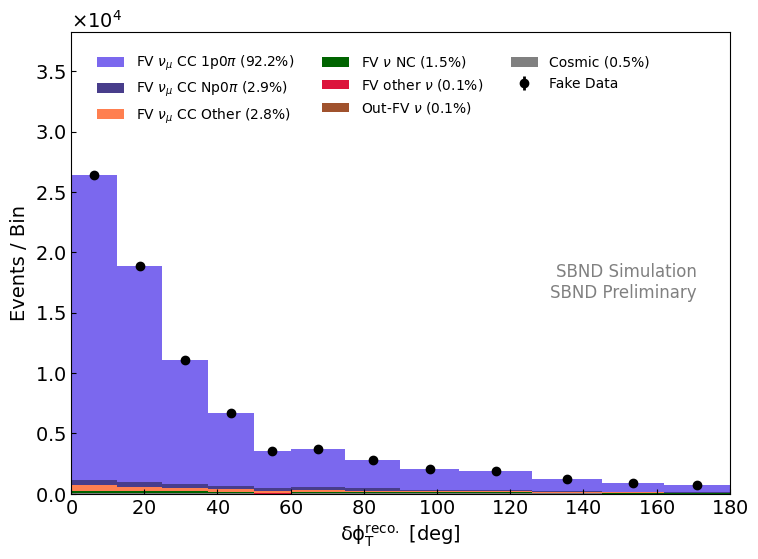

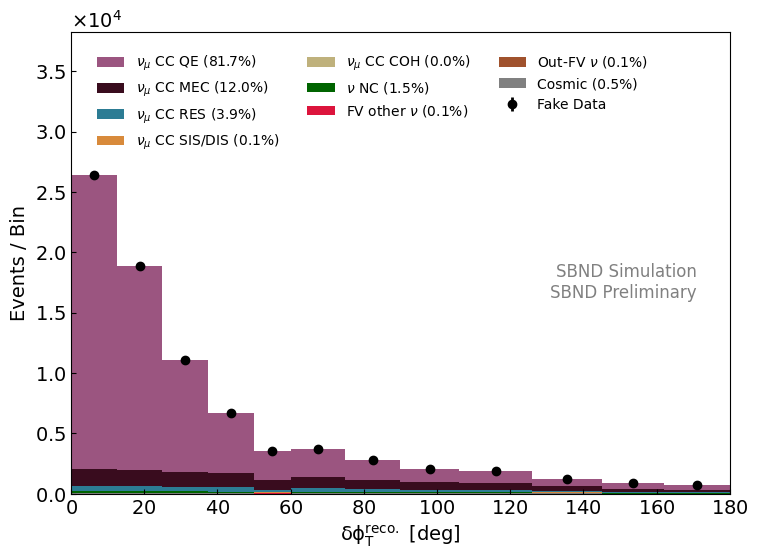

In [1474]:
var_total = var_total_mc
weights_total = weights_total_mc
bins = var_config.bins
plot_labels = [var_config.var_labels[1], "Events / Bin"]

var_categ = var_per_nuint_categ_mc
weights_categ = weights_per_categ
colors = topology_colors
labels = topology_labels
save_name = "{}/{}-closure_test_topology_breakdown.pdf".format(save_fig_dir, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

var_categ = var_per_genie_mode_mc
weights_categ = weights_per_genie_mode
colors = genie_mode_colors
labels = genie_mode_labels
save_name = "{}/{}-closure_test_genie_mode_breakdown.pdf".format(save_fig_dir, var_config.var_save_name)
plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                     plot_labels, 
                     colors=colors, labels=labels,
                     save_fig=save_fig, save_name=save_name)

In [1475]:
Measured = nevts_signal_sel_reco * XSEC_UNIT 
Model = nevts_signal_truth * XSEC_UNIT
Covariance = cov_from_fraccov(frac_cov_matrices[var_name]['mcstat'], nevts_signal_sel_reco) * XSEC_UNIT**2
unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)
print(unfold.keys())
# decomp_cov = Matrix_Decomp(Model, unfold['SystUnfoldCov'])

dict_keys(['unfold', 'AddSmear', 'WF', 'CovRotation', 'StatUnfoldCov', 'SystUnfoldCov', 'UnfoldCov'])


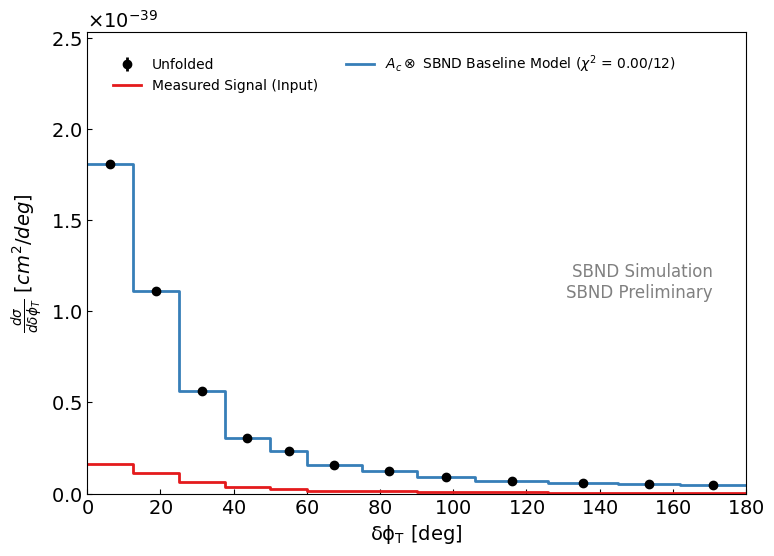

In [1476]:
measured = Measured
bins = var_config.bins
models = [Model]
model_names = ["SBND Baseline Model"]
plot_labels = [var_config.var_labels[0], var_config.xsec_label]
save_name = "{}/{}-closure_test.pdf".format(save_fig_dir, var_config.var_save_name)
plot_unfolded_result(unfold, bins, measured, models, 
                      plot_labels, model_names, 
                      save_fig=save_fig, save_name=save_name,
                      closure_test=True)

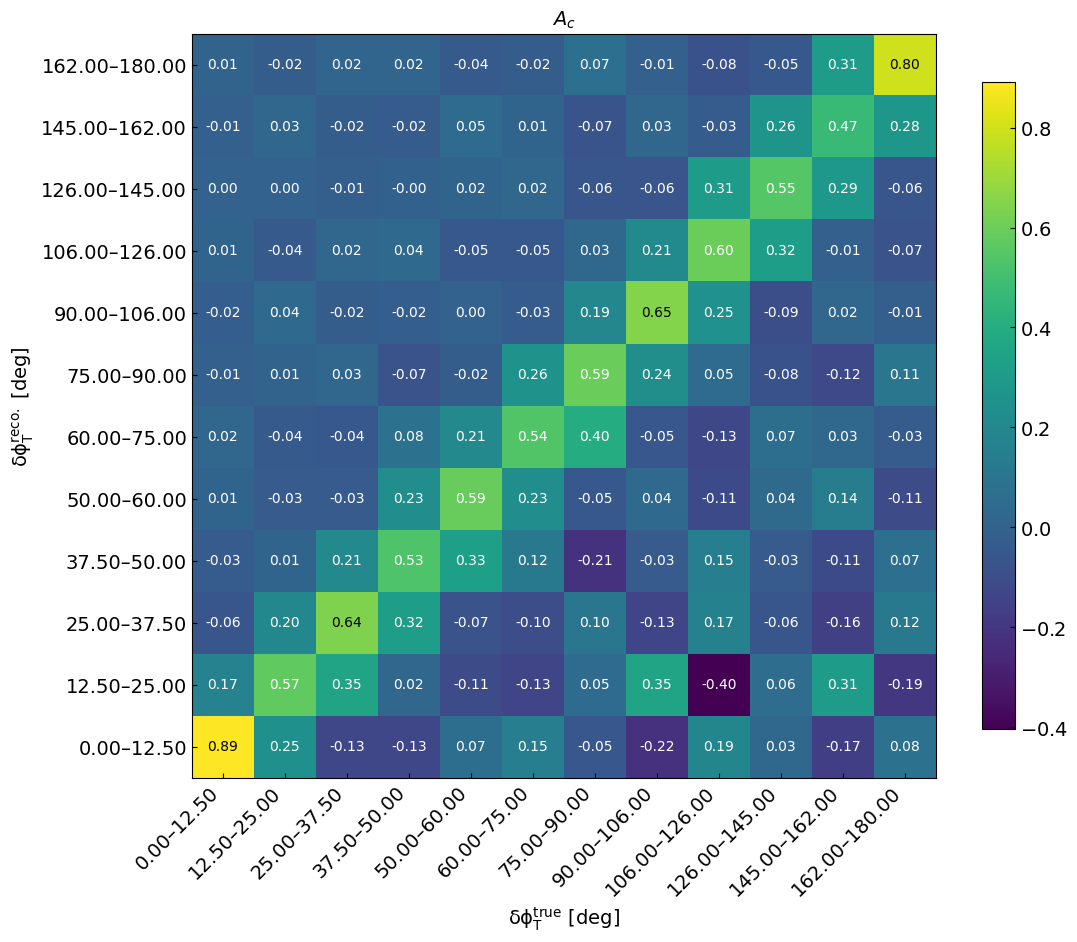

In [1477]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, "closure_test")
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", 
             plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

## Fake Data Tests

- use alternate MC as fake data

In [1478]:
# var_truth_signal = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
# var_truth_signal = np.clip(var_truth_signal, var_config.bins[0], var_config.bins[-1] - eps)
# weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

In [1479]:
# use only stat unc and xsec unc for fake data tests
Covariance_Frac = frac_cov_matrices[var_name]['mcstat'] + frac_cov_matrices[var_name]['genie']
Covariance = cov_from_fraccov(Covariance_Frac, nevts_signal_sel_reco) * XSEC_UNIT**2

### MEC scale

In [1480]:
test_name = "mec_test"

mec_scale = 2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.genie_mode == 10] *= mec_scale

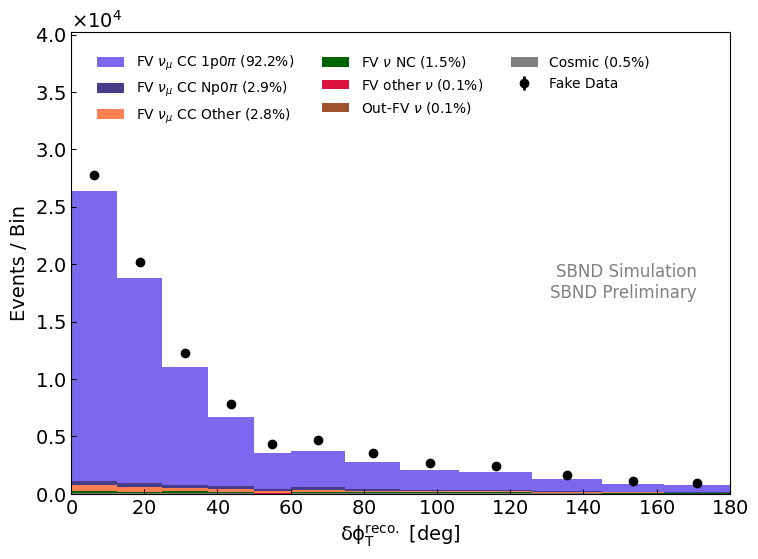

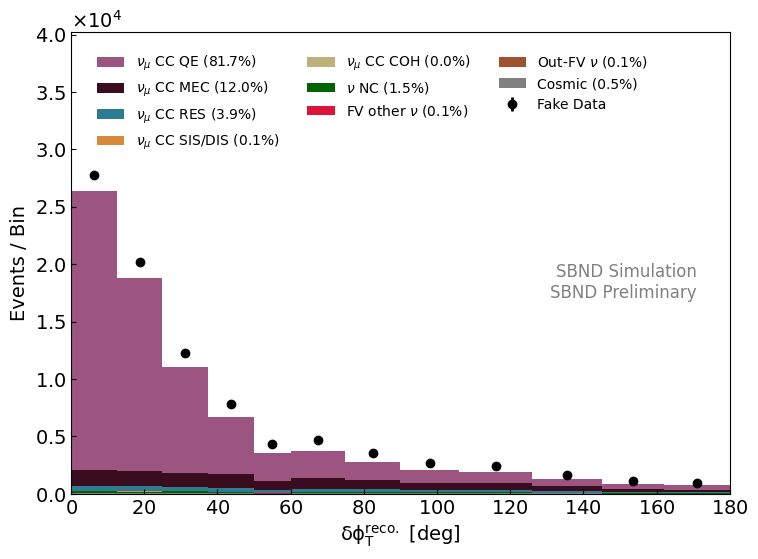

In [1481]:
var_total = var_total_mc
weights_total = weights_total_mc * weights_fake_data
bins = var_config.bins
plot_labels = [var_config.var_labels[1], "Events / Bin"]

var_categ = var_per_nuint_categ_mc
weights_categ = weights_per_categ
colors = topology_colors
labels = topology_labels
save_name = "{}/{}-{}-topology_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

var_categ = var_per_genie_mode_mc
weights_categ = weights_per_genie_mode
colors = genie_mode_colors
labels = genie_mode_labels
save_name = "{}/{}-{}-genie_mode_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                     plot_labels, 
                     colors=colors, labels=labels,
                     save_fig=save_fig, save_name=save_name)

In [1482]:
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT
unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

In [1483]:
mc_pot_scale

1.0

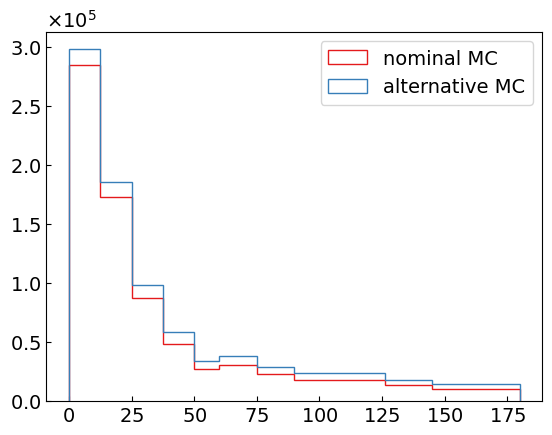

In [1484]:
weight_fakedata_signal_truth = np.ones_like(var_truth_signal) * mc_pot_scale

# nom MC
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="nominal MC")
# print(nevts_fakedata_signal_truth)
# print(nevts_signal_truth)

# alt MC --> fake data
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].genie_mode == 10] = mec_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="alternative MC")
plt.legend()
plt.show()

In [1485]:
# UnfoldCov_syst = unfold['SystUnfoldCov']
# SystUnfoldCov_norm, SystUnfoldCov_shape = Matrix_Decomp(models[0], UnfoldCov_syst)
# Unfold_uncert_norm = np.sqrt(np.diag(SystUnfoldCov_norm))
# Unfold_uncert_shape = np.sqrt(np.diag(SystUnfoldCov_shape))
# np.diag(SystUnfoldCov_norm)

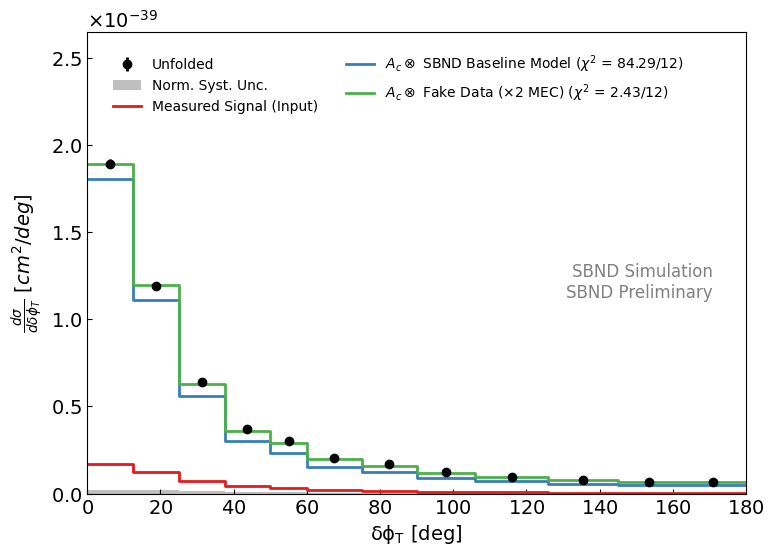

In [1486]:
unfold = unfold
measured = Measured
bins = var_config.bins
models = [Model,  nevts_fakedata_signal_truth*XSEC_UNIT]
model_names = ["SBND Baseline Model", "Fake Data ($\\times${} MEC)".format(mec_scale)]
plot_labels = [var_config.var_labels[0], var_config.xsec_label]
save_name = "{}/{}-{}-unfolded_event_rates.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_unfolded_result(unfold, bins, measured, models, 
                     plot_labels, model_names, save_fig=save_fig, save_name=save_name)

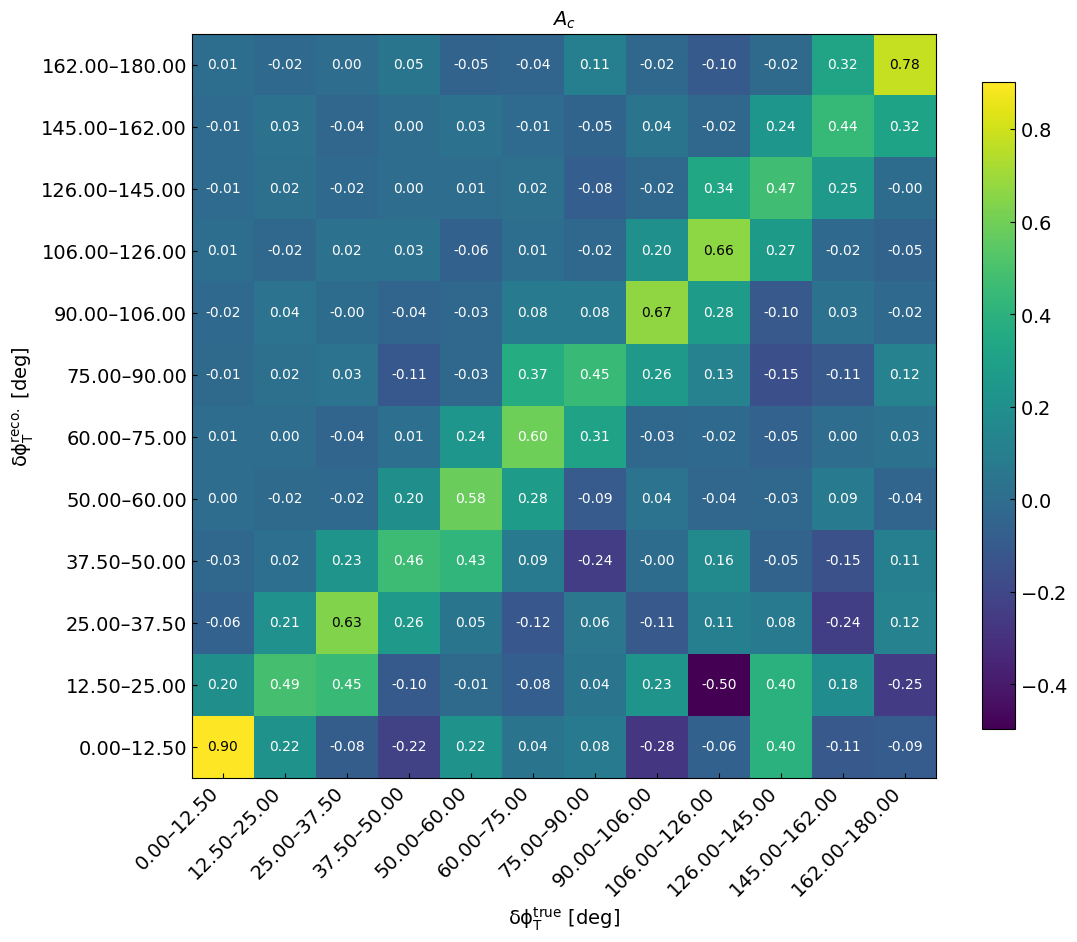

In [1487]:
test_name = "mec_test"
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, test_name, var_config.var_save_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)                                                    

### QE scale

In [1488]:
test_name = "qe_test"

qe_scale = 1.2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.genie_mode == 0] *= qe_scale

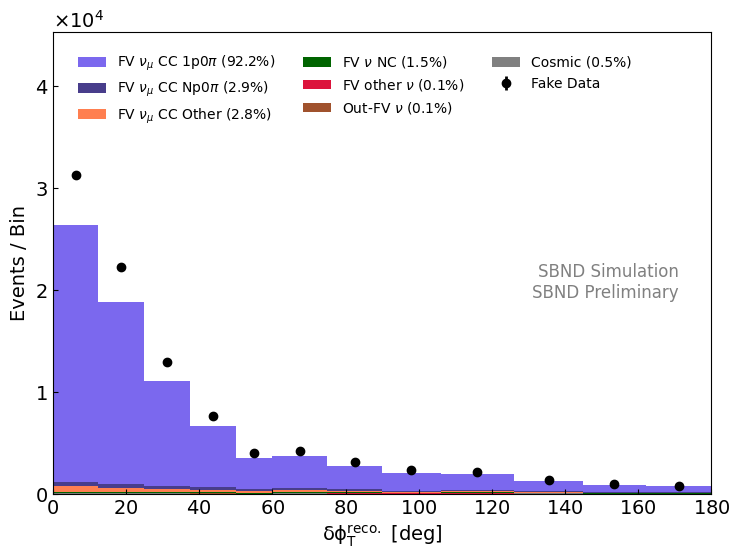

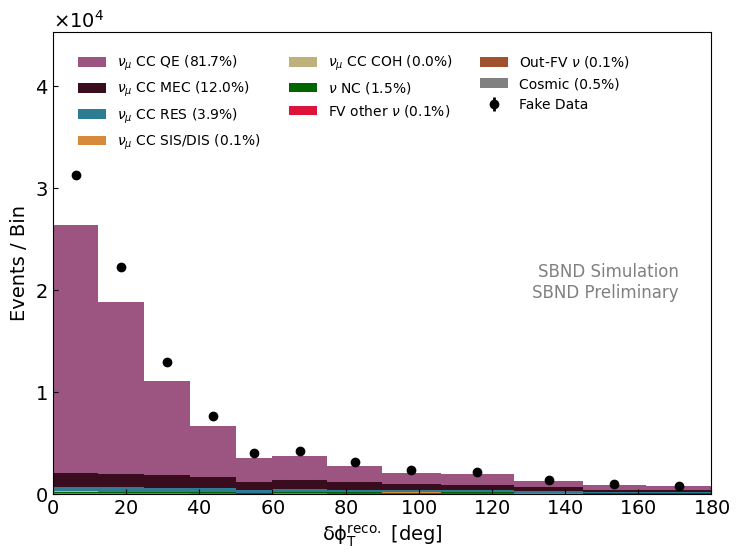

In [1489]:
var_total = var_total_mc
weights_total = weights_total_mc * weights_fake_data
bins = var_config.bins
plot_labels = [var_config.var_labels[1], "Events / Bin"]

var_categ = var_per_nuint_categ_mc
weights_categ = weights_per_categ
colors = topology_colors
labels = topology_labels
save_name = "{}/{}-{}-topology_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

var_categ = var_per_genie_mode_mc
weights_categ = weights_per_genie_mode
colors = genie_mode_colors
labels = genie_mode_labels
save_name = "{}/{}-{}-genie_mode_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                     plot_labels, 
                     colors=colors, labels=labels,
                     save_fig=save_fig, save_name=save_name)

In [1490]:
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT
unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

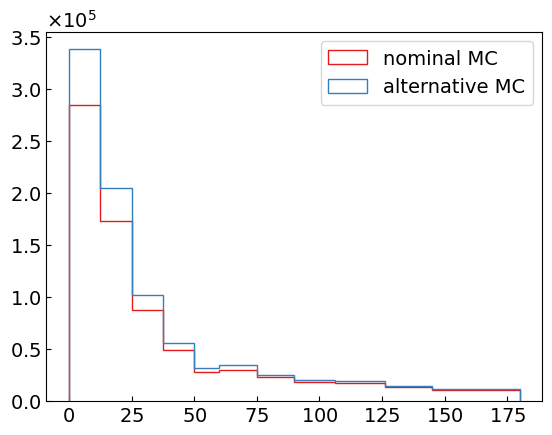

In [1491]:
weight_fakedata_signal_truth = weight_truth_signal.copy()

# nom MC
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="nominal MC")

# alt MC --> fake data
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].genie_mode == 0] = qe_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="alternative MC")
plt.legend()
plt.show()

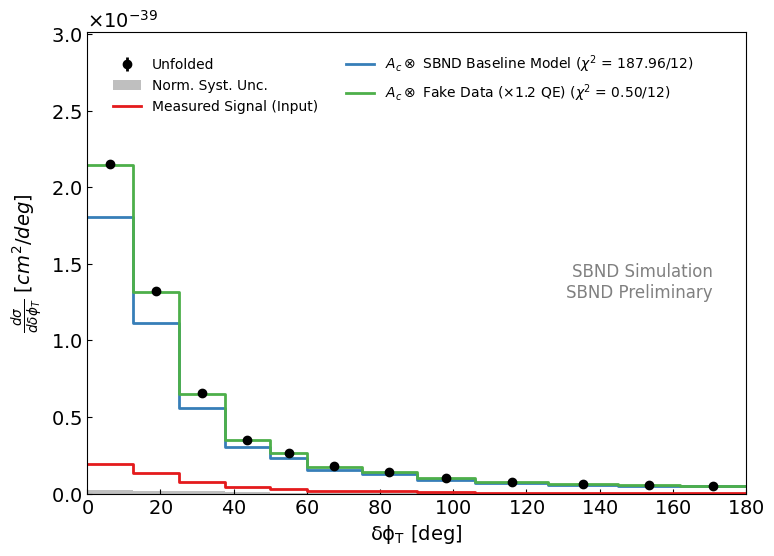

In [1492]:
unfold = unfold
measured = Measured
bins = var_config.bins
models = [Model,  nevts_fakedata_signal_truth*XSEC_UNIT]
model_names = ["SBND Baseline Model", "Fake Data ($\\times${} QE)".format(qe_scale)]
plot_labels = [var_config.var_labels[0], var_config.xsec_label]
save_name = "{}/{}-{}-unfolded_event_rates.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_unfolded_result(unfold, bins, measured, models, 
                     plot_labels, model_names, 
                     save_fig=save_fig, save_name=save_name)

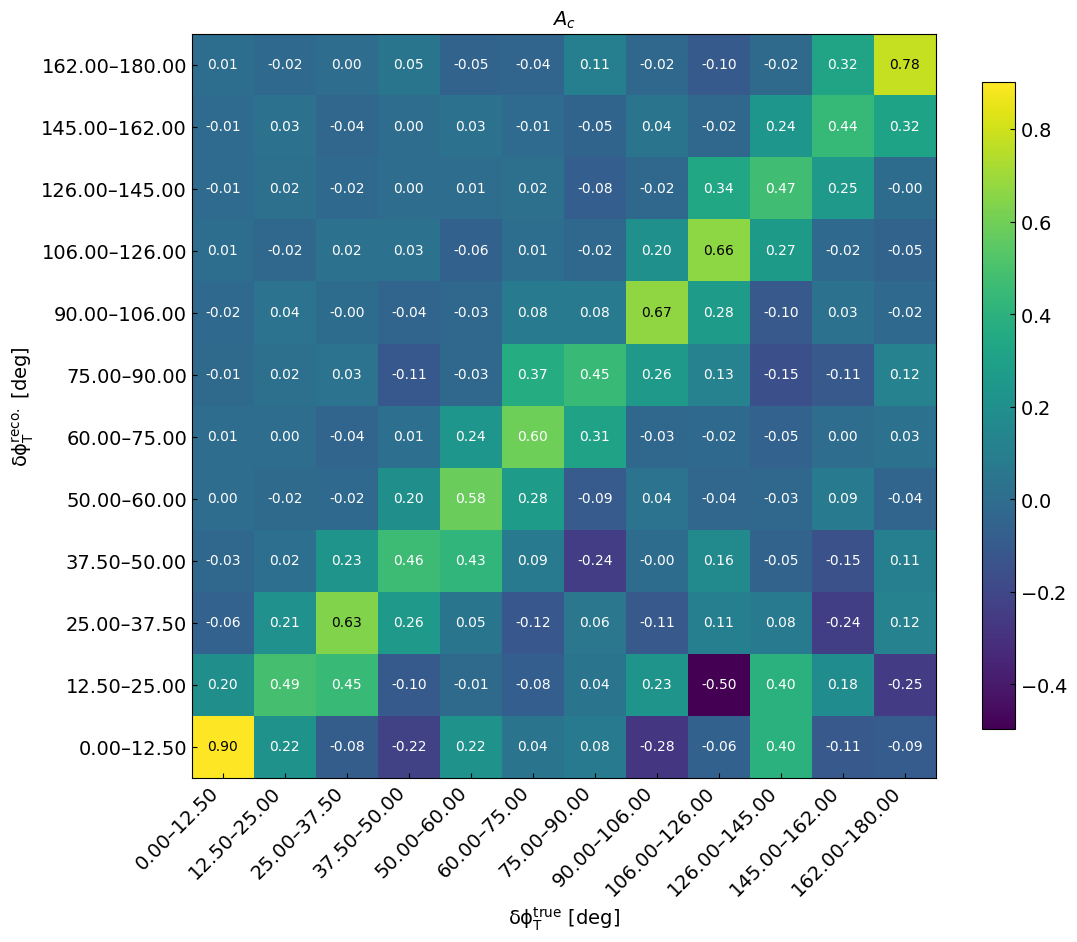

In [1493]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, test_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

# Closure Tests for the Fake Data Tests

### Np background scale

In [1494]:
Np_scale = 2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.nuint_categ == 2] = Np_scale
test_name = "np_test"

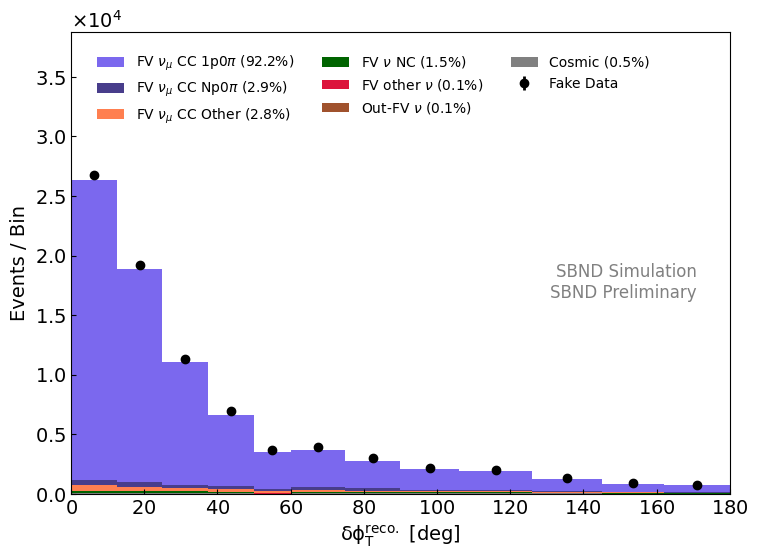

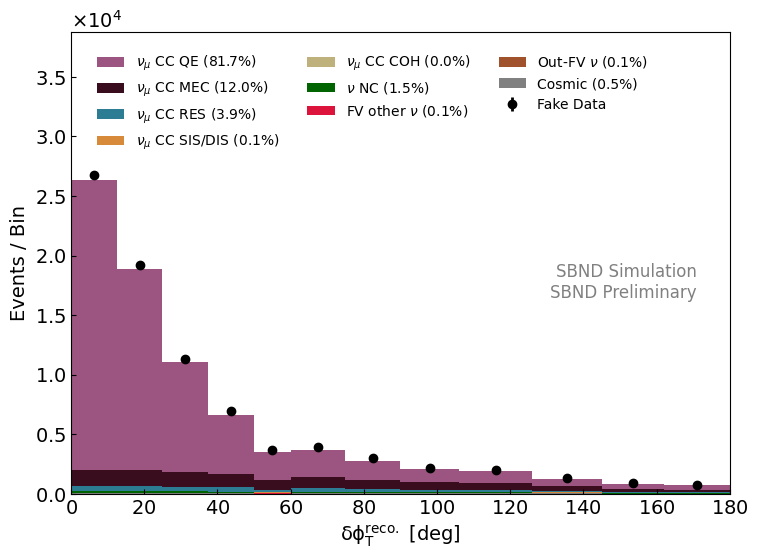

In [1495]:
var_categ = var_per_nuint_categ_mc
weights_categ = weights_per_categ
colors = topology_colors
labels = topology_labels
var_total = var_total_mc
weights_total = weights_total_mc * weights_fake_data
bins = var_config.bins

plot_labels = [var_config.var_labels[1], "Events / Bin"]
save_name = "{}/{}-{}-topology_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

var_categ = var_per_genie_mode_mc
weights_categ = weights_per_genie_mode
colors = genie_mode_colors
labels = genie_mode_labels
save_name = "{}/{}-{}-genie_mode_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                     plot_labels, 
                     colors=colors, labels=labels,
                     save_fig=save_fig, save_name=save_name)

In [1496]:
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT
unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

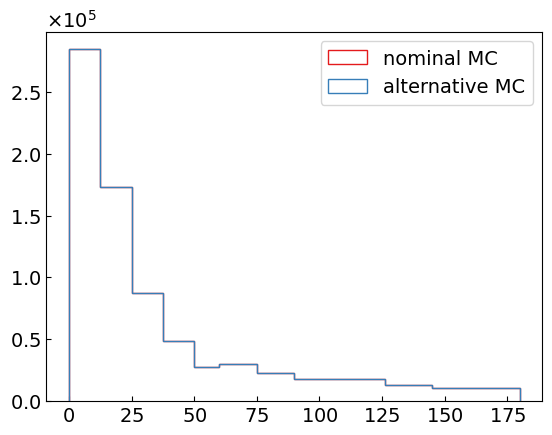

In [1497]:
weight_fakedata_signal_truth = weight_truth_signal.copy()

# nom MC
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="nominal MC")

# alt MC --> fake data
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].nuint_categ == 2] = Np_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="alternative MC")
plt.legend()
plt.show()

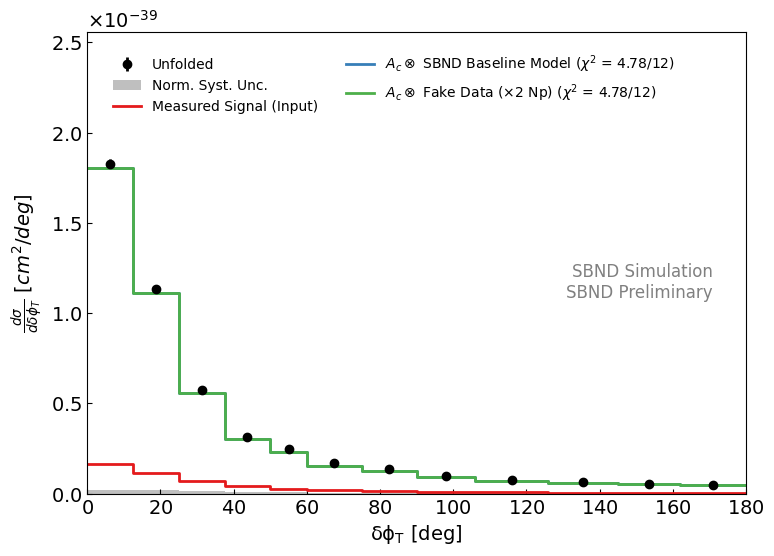

In [1498]:
unfold = unfold
measured = Measured
bins = var_config.bins
models = [Model,  nevts_fakedata_signal_truth*XSEC_UNIT]
model_names = ["SBND Baseline Model", "Fake Data ($\\times${} Np)".format(Np_scale)]
plot_labels = [var_config.var_labels[0], var_config.xsec_label]
save_name = "{}/{}-{}-unfolded_event_rates.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_unfolded_result(unfold, bins, measured, models, plot_labels, model_names, save_fig=save_fig, save_name=save_name)

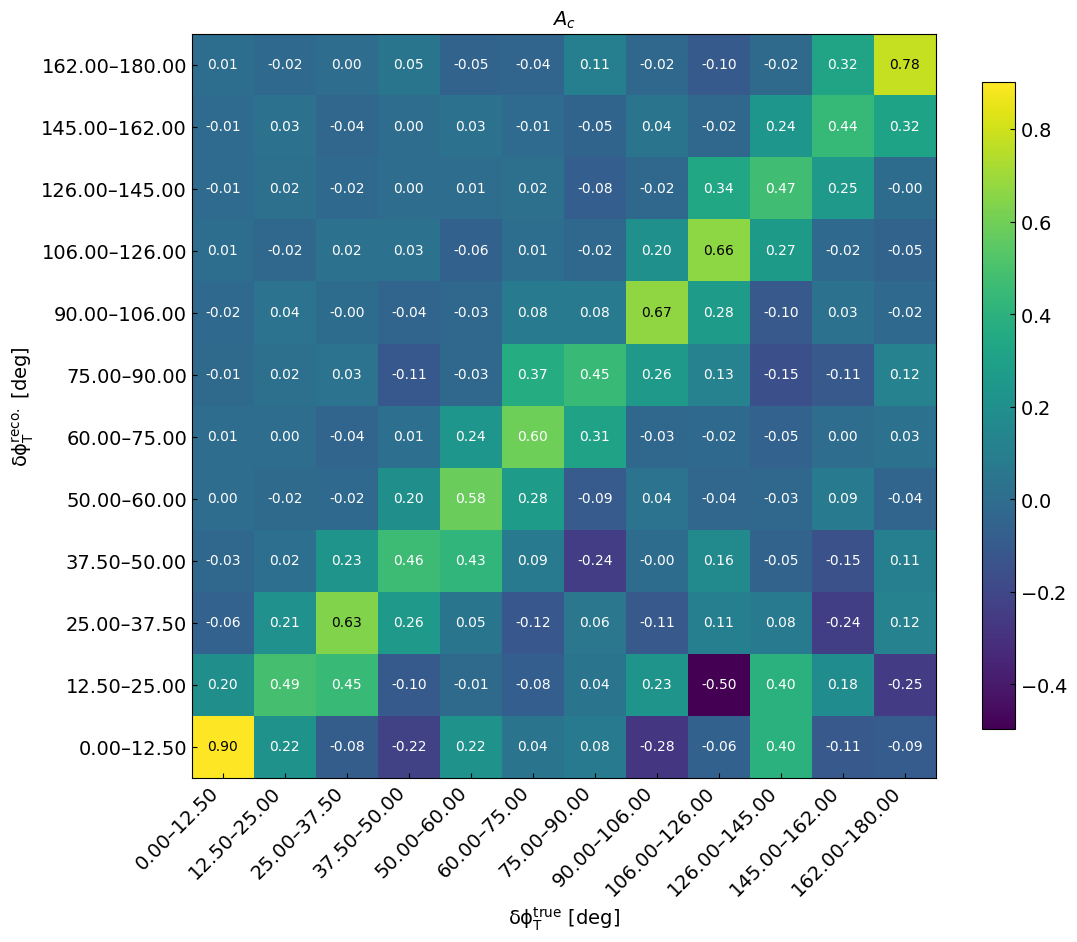

In [1499]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, test_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

### Signal scale

In [1500]:
sig_scale = 1.2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.nuint_categ == 1] = sig_scale
test_name = "sig_test"

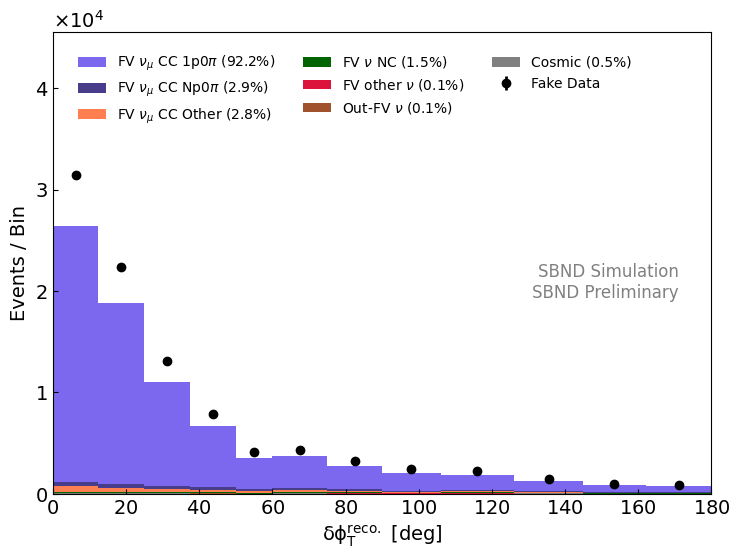

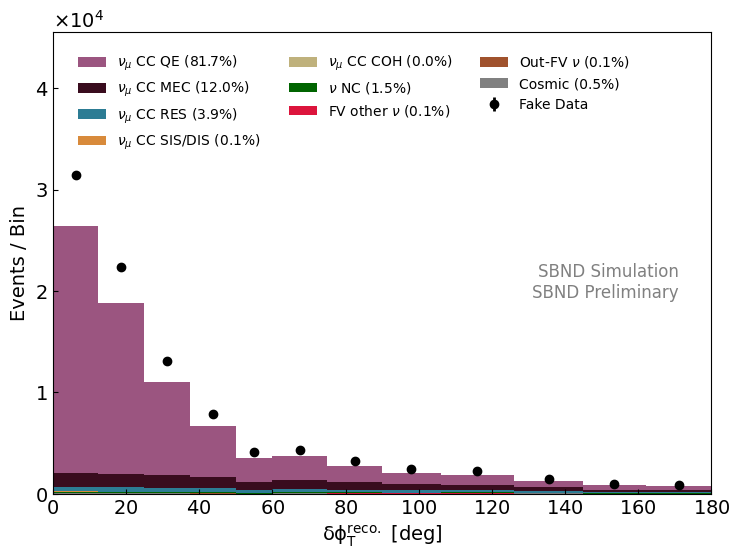

In [1501]:
var_categ = var_per_nuint_categ_mc
weights_categ = weights_per_categ
colors = topology_colors
labels = topology_labels
var_total = var_total_mc
weights_total = weights_total_mc * weights_fake_data
bins = var_config.bins
plot_labels = [var_config.var_labels[1], "Events / Bin"]
save_name = "{}/{}-{}-topology_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

var_categ = var_per_genie_mode_mc
weights_categ = weights_per_genie_mode
colors = genie_mode_colors
labels = genie_mode_labels
save_name = "{}/{}-{}-genie_mode_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                     plot_labels, 
                     colors=colors, labels=labels,
                     save_fig=save_fig, save_name=save_name)

In [1502]:
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT
unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

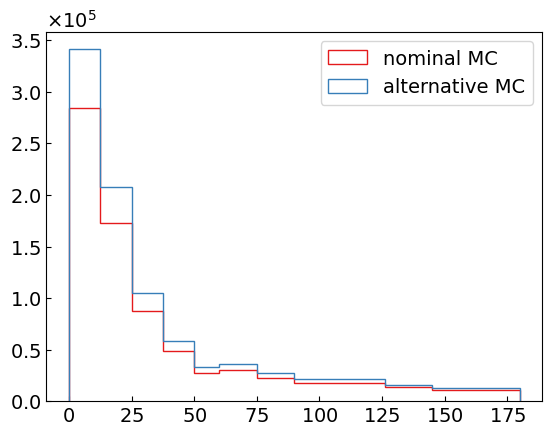

In [1503]:
weight_fakedata_signal_truth = weight_truth_signal.copy()

# nom MC
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="nominal MC")

# alt MC --> fake data
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].nuint_categ == 1] = sig_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_fakedata_signal_truth, 
                                             histtype="step", label="alternative MC")
plt.legend()
plt.show()

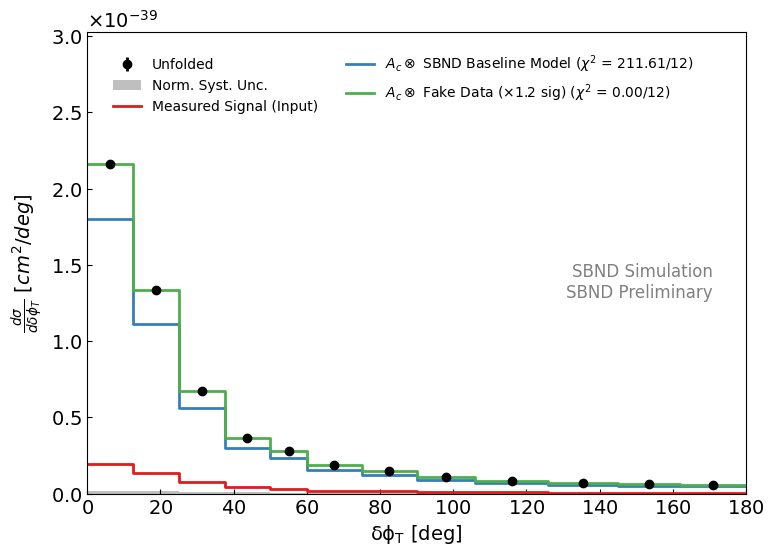

In [1504]:
unfold = unfold
measured = Measured
bins = var_config.bins
models = [Model,  nevts_fakedata_signal_truth*XSEC_UNIT]
model_names = ["SBND Baseline Model", "Fake Data ($\\times${} sig)".format(sig_scale)]
plot_labels = [var_config.var_labels[0], var_config.xsec_label]
save_name = "{}/{}-{}-unfolded_event_rates.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_unfolded_result(unfold, bins, measured, models, plot_labels, model_names, save_fig=save_fig, save_name=save_name)

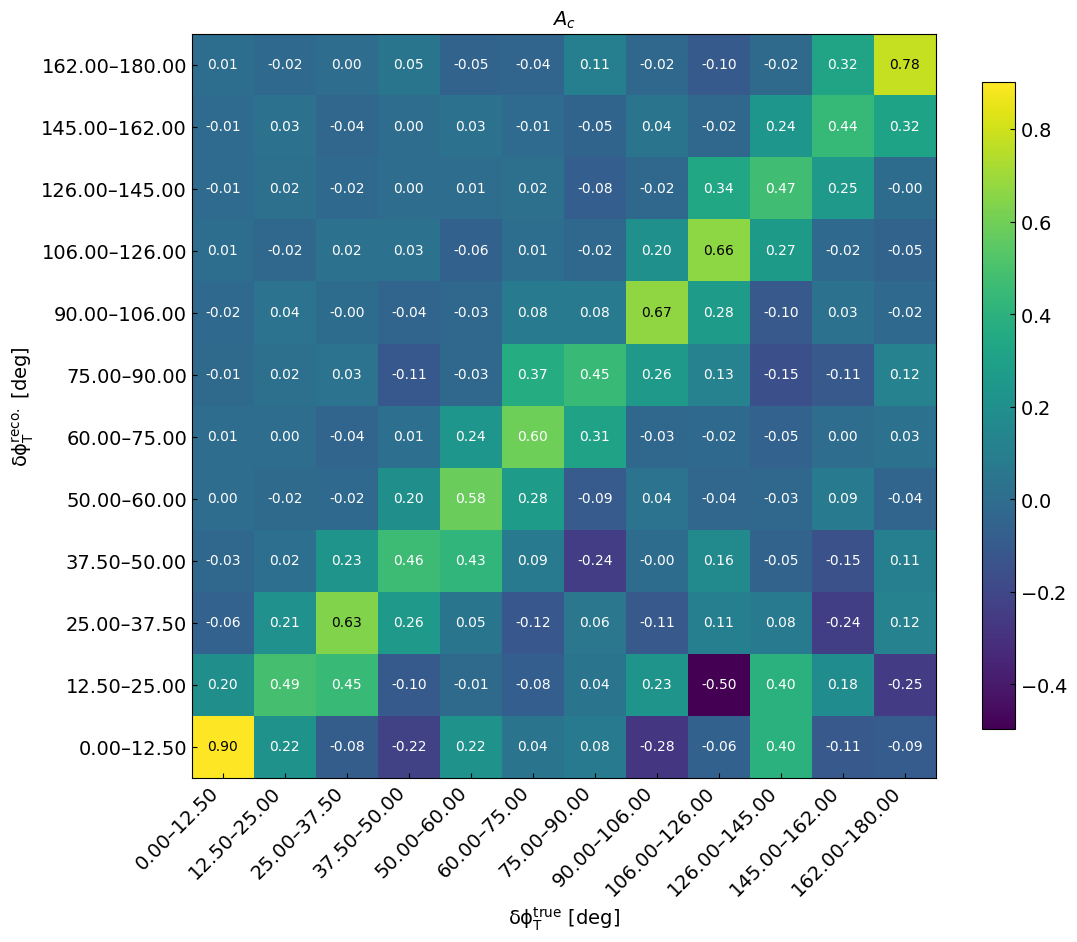

In [1505]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, test_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)